In [2]:
%load_ext autoreload
%autoreload 2
from IPython.display import clear_output
import os
import fnmatch
import numpy as np
import pickle
import matplotlib.pyplot as plt
import umap
from sklearn.mixture import GaussianMixture
from scipy import stats
# from sklearn.cluster import OPTICS

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.backend import mean
from tensorflow.keras.backend import square
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Flatten

from tensorflow.keras.utils import Sequence
from tensorflow.keras import Input
from tensorflow.keras import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D
from scipy.stats import zscore

plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.rcParams.update({'font.size': 12})
plt.rcParams.update(plt.rcParamsDefault)

np.random.seed(seed=11)


cwd = os.getcwd()

if cwd.split("/")[1] == "export":
    data_dir = "../../../files_from_snuffy"
else:
    data_dir = "../../../data_GRS1915"


/home/jkok1g14/anaconda3/envs/jakub-tf/lib/python3.5/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/jkok1g14/anaconda3/envs/jakub-tf/lib/python3.5/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/jkok1g14/anaconda3/envs/jakub-tf/lib/python3.5/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [25]:
segments_dir = '{}/468202_len128_s2_4cad_counts_errorfix.pkl'.format(data_dir)
errors_dir = '{}/468202_len128_s2_4cad_errors_errorfix.pkl'.format(data_dir)
recos_dir = "{}/reconstructions_from_model_2020-04-29_09-12-23.pkl".format(data_dir)

with open(segments_dir, 'rb') as f:
    segments = pickle.load(f)
with open(errors_dir, 'rb') as f:
    errors = pickle.load(f)
with open(recos_dir, 'rb') as f:
    recos = pickle.load(f)

recos= recos*np.std(segments, axis=1) + np.mean(segments, axis=1)

# errors = ((errors)/np.expand_dims(np.std(segments, axis=1), axis=1)).astype(np.float32)
# segments = zscore(segments, axis=1).astype(np.float32)  # standardize per segment

In [39]:
# load observation classifications from Huppenkothen 2017
clean_belloni = open('{}/1915Belloniclass_updated.dat'.format(data_dir))
lines = clean_belloni.readlines()
states = lines[0].split()
belloni_clean = {}
for h,l in zip(states, lines[1:]):
    belloni_clean[h] = l.split()
    #state: obsID1, obsID2...
ob_state = {}
for state, obs in belloni_clean.items():
    if state == "chi1" or state == "chi2" or state == "chi3" or state == "chi4": state = "chi"
    for ob in obs:
        ob_state[ob] = state
        
# load IDs of segmented light curves: observationsID_segmentIndex
with open('{}/468202_len128_s2_4cad_ids_errorfix.pkl'.format(data_dir), 'rb') as f:
    seg_ids = pickle.load(f)

        
seg_ObIDs = [seg.split("_")[0] for seg in seg_ids] # get rid of the within-observation segment indices and create a degenerate list of observation IDs

classes = np.array(["alpha", "beta", "gamma", "delta", "theta", "kappa", "lambda", "mu", "nu", "rho", "phi", "chi", "eta", "omega"])
scales = []
segment_class = []
for ob in seg_ObIDs:
    if ob in ob_state:
        segment_class.append(ob_state[ob])
    else:
        segment_class.append("Unknown")

In [ ]:
seg_ind=18

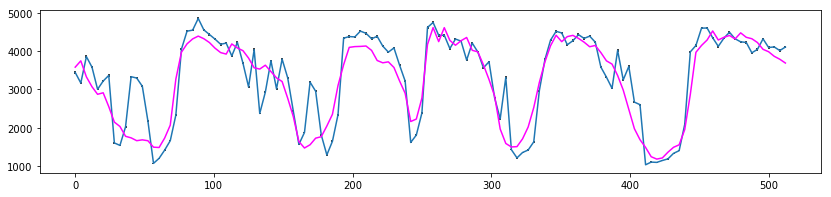

In [152]:
seg_ind+=1
pylab.rcParams['figure.figsize'] = (14, 3)
plt.errorbar(np.linspace(0,512, num=128), segments[seg_ind], yerr=errors[seg_ind], ecolor="black")

plt.plot(np.linspace(0,512, num=128), recos[seg_ind], c="magenta", zorder=5)
plt.show()

In [42]:
np.where(np.array(segment_class) == "alpha")

(array([    65,    229,    261, ..., 468069, 468090, 468096]),)

/home/jkok1g14/anaconda3/envs/jakub-tf/lib/python3.5/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


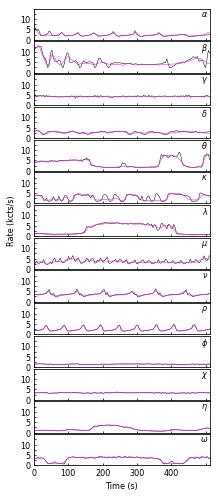

In [184]:
# with open('../../../data_GRS1915/1776_light_curves_1s_bin_errorfix.pkl', 'rb') as f:
#     lcs = pickle.load(f)
# with open('../../../data_GRS1915/1776_light_curves_1s_bin_ids_errorfix.pkl', 'rb') as f:
#     ids = pickle.load(f)
    
    
# clean_belloni = open('../../../data_GRS1915/1915Belloniclass_updated.dat')
# lines = clean_belloni.readlines()
# states = lines[0].split()
# belloni_clean = {}
# for h,l in zip(states, lines[1:]):
#     belloni_clean[h] = l.split()
#     #state: obsID1, obsID2...
# ob_state = {}
# for state, obs in belloni_clean.items():
#     if state == "chi1" or state == "chi2" or state == "chi3" or state == "chi4": state = "chi"
#     for ob in obs:
#         ob_state[ob] = state


        

# inv_ob_state = {}
# for k, v in ob_state.items():
#     inv_ob_state[v] = inv_ob_state.get(v, [])
#     inv_ob_state[v].append(k)


import matplotlib.pylab as pylab
import matplotlib.ticker as ticker
#https://stackoverflow.com/questions/8389636/creating-over-20-unique-legend-colors-using-matplotlib


pylab.rcParams['figure.figsize'] = (3.15, 8.4) # A4 size 210mm x 297mm

# colors = matplotlib.colors.CSS4_COLORS.keys()
# colors = np.array(list(colors))


# NUM_COLORS = 14
# cm = plt.get_cmap("jet")#('gist_rainbow')
# colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

ids_ar = np.array(segment_class)

# class_names = list(inv_ob_state.keys())


alpha = np.where(ids_ar == "alpha")[0][1]#1
beta= np.where(ids_ar == "beta")[0][7]#7
gamma=np.where(ids_ar == "gamma")[0][4]
delta=np.where(ids_ar == "delta")[0][5]
theta=np.where(ids_ar == "theta")[0][4]#4
kappa=np.where(ids_ar == "kappa")[0][3]
lambda1=np.where(ids_ar == "lambda")[0][2]
mu=np.where(ids_ar == "mu")[0][1]
nu=np.where(ids_ar == "nu")[0][1]
rho=np.where(ids_ar == "rho")[0][1]
phi=np.where(ids_ar == "phi")[0][1]
chi=np.where(ids_ar == "chi")[0][1]
eta=np.where(ids_ar == "eta")[0][4]
omega=np.where(ids_ar == "omega")[0][3]


selected_lcs = [alpha,beta,gamma,delta,theta,kappa,lambda1,mu,nu,rho,phi,chi,eta,omega]


fig, axes = plt.subplots(nrows=14, ncols=1)
axes = axes.flatten()

plt.subplots_adjust(hspace=0.05)
plt.subplots_adjust(wspace=0.01)

# good_classes = ["delta", "mu", "rho", "phi"]
intervals = {}

class_names = np.array(["alpha", "beta", "gamma", "delta", "theta", "kappa", "lambda", "mu", "nu", "rho", "phi", "chi", "eta", "omega"])


for plot_ind in range(14):
    light_c = selected_lcs[plot_ind]
    class_name = class_names[plot_ind]    
    axes[plot_ind].plot(np.linspace(0,512, num=128), segments[light_c], c="black", linewidth=0.5, zorder=1, label="Input")
    axes[plot_ind].plot(np.linspace(0,512, num=128), recos[light_c], c="magenta", linewidth=0.5, zorder=2, label="Reconstruction")
    axes[plot_ind].set_ylim([0, 15000])
    axes[plot_ind].set_xlim([0, 512])
    axes[plot_ind].text(0.99,0.99,r"$\{}$".format(class_name), ha='right', va='top', transform=axes[plot_ind].transAxes, size=8)
        
    axes[plot_ind].tick_params(axis="y", which="major", length=2, width=0.75, labelsize=8, direction="in")
#     axes[plot_ind].tick_params(axis="y", which="minor", length=2, width=0.75, labelsize=8, direction="in")


#     if plot_ind%2 == 0:
#         axes[plot_ind].tick_params(axis="y", which="major", length=5, width=1, labelsize=8, direction="in")
#     else:
#         axes[plot_ind].tick_params(axis="y", which="major", length=5, width=1, labelsize=0, direction="in")
#         plt.setp(axes[plot_ind].get_yticklabels(), visible=False)

    if plot_ind == 6:
        axes[plot_ind].set_ylabel("Rate (kcts/s)", size=8)
    if plot_ind == 13:#plot_ind == 12 or plot_ind == 13
        axes[plot_ind].tick_params(axis="x", which="major", length=2, width=0.75, labelsize=8, direction="in")
        axes[plot_ind].set_xlabel("Time (s)", size=8)

    else:
        axes[plot_ind].tick_params(axis="x", which="major", length=2, width=0.75, labelsize=0, direction="in")
        plt.setp(axes[plot_ind].get_xticklabels(), visible=False)
    
#     axes[plot_ind].set_yticks([0, 2000, 4000, 6000, 8000, 10000, 12000, 14000])
#     axes[plot_ind].set_yticklabels([0, "", "", 6, "", "", 12, ""])
    axes[plot_ind].set_yticks([0, 2500, 5000, 7500, 10000, 12500])
    axes[plot_ind].set_yticklabels([0, "", 5, "", 10, "",])
    axes[plot_ind].set_xticks([0, 100, 200,300, 400, 500])
    axes[plot_ind].set_xticklabels([0, 100, 200,300, 400, ""])

    
axes.reshape((14,1))


# axes[0][0].tick_params(axis="x", which="major", length=5, width=1, labelsize=5, direction="in")
# axes[0][1].tick_params(axis="x", which="major", length=5, width=1, labelsize=5, direction="in")
# axes[1][0].tick_params(axis="x", which="major", length=5, width=1, labelsize=25, direction="in")
# axes[1][1].tick_params(axis="x", which="major", length=5, width=1, labelsize=25, direction="in")

# axes[0][0].tick_params(axis="y", which="major", length=5, width=1, labelsize=25, direction="in")
# axes[1][0].tick_params(axis="y", which="major", length=5, width=1, labelsize=25, direction="in")
# axes[0][1].tick_params(axis="y", which="major", length=5, width=1, labelsize=5, direction="in")
# axes[1][1].tick_params(axis="y", which="major", length=5, width=1, labelsize=5, direction="in")

# plt.setp(axes[0][1].get_yticklabels(), visible=False)
# plt.setp(axes[1][1].get_yticklabels(), visible=False)
# plt.setp(axes[0][1].get_xticklabels(), visible=False)
# plt.setp(axes[0][0].get_xticklabels(), visible=False)

# axes[1][0].set_xticks([500,1000,1500,2000])
# axes[1][1].set_xticks([500,1000,1500,2000])


# axes[0][0].yaxis.set_label_coords(-0.2, 0)
# axes[1][0].xaxis.set_label_coords(1, -0.1)

# plt.suptitle("14 classes of activity of x-ray black hole binary GRS1915+105", fontsize=40, y=0.92)


plt.savefig('all_classes_of_GRS1915_segments_with_reconstructions.png', dpi=300)
# plt.legend()
fig.show()

In [55]:
np.where(ids_ar == "lambda")[0]

array([   321,    396,    556, ..., 467447, 467955, 468154])

In [54]:
lcs[np.where(ids_ar == "lambda")[0]]

array([[[4610.75],
        [3583.75],
        [3483.5 ],
        ...,
        [5404.5 ],
        [4621.5 ],
        [2756.25]],

       [[3805.25],
        [3768.  ],
        [5229.  ],
        ...,
        [3380.  ],
        [4133.  ],
        [5077.25]],

       [[1460.5 ],
        [1431.5 ],
        [1352.75],
        ...,
        [ 707.  ],
        [ 725.75],
        [ 705.5 ]],

       ...,

       [[ 676.25],
        [ 697.25],
        [ 643.25],
        ...,
        [4653.  ],
        [5167.5 ],
        [5616.25]],

       [[4344.5 ],
        [4663.25],
        [4836.75],
        ...,
        [2879.5 ],
        [4221.5 ],
        [2850.75]],

       [[3627.25],
        [4694.25],
        [4315.25],
        ...,
        [1716.  ],
        [1768.25],
        [1848.75]]])